In [1]:
from huggingface_hub import login
import pandas as pd
from transformers import LlamaTokenizer, AutoModelForCausalLM
import torch
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from textblob import TextBlob
import textstat
import spacy

nlp = spacy.load("en_core_web_sm")

# Log in to Hugging Face with your token
huggingface_token = "Add your hugging face token here"
login(token=huggingface_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
model_name = "mistralai/Mistral-7B-Instruct-v0.3"

# Use LlamaTokenizer for Mistral models, as Mistral is compatible with LLaMA tokenizer
tokenizer = LlamaTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Ensure the model is loaded onto the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32768, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRM

In [3]:
torch.cuda.empty_cache()

In [4]:
# Load dataset
csv_file = "filtered_data_predictions_clusters.csv"
df = pd.read_csv(csv_file)

# Filter dataset for testing with 40 products
unique_products = df['name'].unique()[:40]
filtered_df = df[df['name'].isin(unique_products)]

# Ensure columns are strings and handle NaNs
filtered_df['reviews.title'] = filtered_df['reviews.title'].fillna('').astype(str)
filtered_df['reviews.text'] = filtered_df['reviews.text'].fillna('').astype(str)

# Concatenate reviews for each product
grouped_reviews = filtered_df.groupby("name").agg({
    "reviews.title": " ".join,
    "reviews.text": " ".join
}).reset_index()

/tmp/ipykernel_220/3310812619.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['reviews.title'] = filtered_df['reviews.title'].fillna('').astype(str)
/tmp/ipykernel_220/3310812619.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['reviews.text'] = filtered_df['reviews.text'].fillna('').astype(str)


In [5]:
#specific promptreview summaries
review_prompt_template = "Provide a two-sentence summary of the main strengths and weaknesses for this product based on user reviews: {}"

In [6]:
def evaluate_outputs(results):
    print("\nEvaluation of Summarized Outputs:")
    print("=" * 60)

    for i, entry in enumerate(results, 1):
        print(f"\nProduct Name: {entry['product_name']}")
        print(f"Title Summary (1 sentence):\n  {entry['title_summary']}")
        print(f"Review Summary (2 sentences):\n  {entry['review_summary']}")
        print("=" * 60)

In [7]:
def generate_summary(prompt, max_new_tokens=20, temperature=0.5, repetition_penalty=1.8, is_title=False):
    # Adjust parameters for titles
    if is_title:
        max_new_tokens = 50  # Increase slightly for more complete titles
        repetition_penalty = 1.8  # Reduce redundancy
        temperature=5

    # Generate title or summary
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    summary_ids = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        repetition_penalty=repetition_penalty,
        num_beams=3,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode and return output
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True).strip()

In [8]:
# Synonyms for variety
synonyms = {
    "great": ["excellent", "outstanding", "impressive"],
    "good": ["satisfactory", "decent", "suitable"],
    "easy": ["straightforward", "simple", "user-friendly"],
    "awesome": ["fantastic", "remarkable", "incredible"],
    "price": ["cost", "value", "affordability"],
}

def post_process(text):
    # Patterns for prompt artifacts
    prompt_patterns = [
        r"^Create a one-sentence title summarizing.*:?\s*",
        r"^Provide a two-sentence summary.*:?\s*",
        r"^Focus on unique qualities only.*:?\s*",
        r"^Generate a 5-word title that summarizes the key.*:?\s",
        r"^.*summarizing.*:\s*",  # Remove 'summarizing' patterns
        r"^.*summary.*:\s*",      # Remove 'summary' patterns
        r"^.*qualities only.*:\s*",  # Remove 'qualities only' patterns
        r"^.*summarizes the key.*:\s*",  # Remove 'summarizes the key' patterns
        r"^Strengths:\s*",  # Remove 'Strengths:' leading label
        r"^Weaknesses:\s*",  # Remove 'Weaknesses:' leading label
        r"\s*Strengths:\s*",  # Remove 'Strengths:' inline label
        r"\s*Example:\s*"  
        r"\s*Review:\s*"
        r"^Examples?:\s*",          # Lines starting with "Example:" or "Examples:"
        r"^- Review\s*:\s*",        # Lines starting with "- Review:"
        r"^Main Weaknesses?:\s*",   # Lines starting with "Main Weaknesses:"
        r"^\d+\.",                  # Removes any numbered lists at the start of a line (e.g., "1.")
        r"^-",                      # Removes lines starting with a dash or hyphen
        r"^\s*"                     # Remove extra whitespace-only lines    
    ]
    
    # Remove initial prompt text and track changes
    for pattern in prompt_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE).strip()
    
    # 2. Ensure text ends at the last complete sentence
    last_period_index = text.rfind(".")
    if last_period_index != -1:
        text = text[:last_period_index + 1]   
        
    # Split into sentences and filter out fragments
    sentences = re.split(r'(?<=\w[.!?])\s+', text)
    sentences = [s for s in sentences if s and len(s.split()) > 3]
    
    # Synonym replacement for variety
    for i, sentence in enumerate(sentences):
        for word, syn_list in synonyms.items():
            if word in sentence:
                synonym = random.choice(syn_list)
                sentence = re.sub(r'\b{}\b'.format(word), synonym, sentence, flags=re.IGNORECASE)
        sentences[i] = sentence
    
    # Add contextual phrases if applicable
    final_sentences = []
    for sentence in sentences:
        if "kids" in sentence.lower() or "children" in sentence.lower():
            sentence += " Ideal for young users due to its durable and easy-to-use design."
        elif "waterproof" in sentence.lower() or "beach" in sentence.lower():
            sentence += " Perfect for reading outdoors or by the pool."
        final_sentences.append(sentence)
    
    # Recombine the cleaned and enhanced sentences
    processed_text = " ".join(final_sentences)
    
    return processed_text

In [9]:
def post_process_title(text):
    # Locate the last occurrence of "Title:" and keep everything that follows
    last_title_index = text.rfind("Title:")
    if last_title_index != -1:
        text = text[last_title_index + len("Title:"):].strip()

    # Split text into lines for more precise line-by-line processing
    lines = text.splitlines()
    
    # Patterns to remove unwanted artifacts from the title section
    prompt_patterns = [
        r"^Examples?:\s*$",              # Removes "Example:" or "Examples:" lines
        r"^- Review\s*:\s*$",            # Removes "- Review:" lines
        r"^Main Weaknesses?:\s*$",       # Removes "Main Weaknesses:" lines
        r"^Strengths?:\s*$",             # Removes "Strengths:" lines
        r"^\d+\.\s*$",                   # Removes any numbered lists (e.g., "1. ")
        r"^-\s*$",                       # Removes lines starting with "-"
        r"^\s*$"                         # Removes empty lines
    ]

    # Remove lines that match any pattern
    cleaned_lines = []
    for line in lines:
        match = False
        for pattern in prompt_patterns:
            if re.match(pattern, line.strip(), re.IGNORECASE):
                match = True
                break
        if not match:
            cleaned_lines.append(line.strip())

    # Join the cleaned lines back into a single text block
    processed_text = " ".join(cleaned_lines).strip()

    # Remove any quotes and make sure to end with a complete sentence
    processed_text = processed_text.strip('\'"')
    processed_text = processed_text.rsplit('.', 1)[0] + '.'  # Ensure it ends with a complete sentence.

    return processed_text.strip()


In [10]:
def generate_summary_again(review_text, max_new_tokens=80):
    # Set different generation parameters for more diversity and flexibility
    temperature = 1.0  # Higher temperature for more varied responses
    repetition_penalty = 1.2  # Lower penalty to allow a bit of repetition for emphasis

    inputs = tokenizer(review_text, return_tensors="pt", truncation=True).to(device)
    summary_ids = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        repetition_penalty=repetition_penalty,
        num_beams=4,  # Increase beams for more options
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True).strip()

In [11]:
# Generate summaries for each product with dynamic length
results = []
for _, row in grouped_reviews.iterrows():
    product_name = row["name"]
    combined_text = row["reviews.title"] + " " + row["reviews.text"]
    review_prompt = review_prompt_template.format(combined_text[:150])
    review_summary = generate_summary(review_prompt, max_new_tokens=60)
    review_summary = post_process(review_summary)

    # Check if summary is empty and regenerate if needed
    if not review_summary:
        print(f"Regenerating summary for product: {product_name}")
        # Use raw reviews text for regeneration to get a fresh perspective
        review_prompt_2 = review_prompt_template.format(combined_text[150:300])
        #review_text = row["reviews.text"][:500]  # Use a larger chunk of raw text
        review_summary = generate_summary(review_prompt_2, max_new_tokens=80)
        print(product_name)
        print("regenerated summary before post-processing:", review_summary)
        # Optional: Further post-process the regenerated summary if needed
        review_summary = post_process(review_summary)
        print("regenerated summary after post-processing:", review_summary)

   # Use an example-enhanced prompt for title generation
    example_titles = """
    Examples:
    - Review: "This tablet has amazing battery life and is very user-friendly."
      Title: "Long Battery Life and Easy to Use"
    - Review: "The Kindle Fire is perfect for kids, durable, and affordable."
      Title: "Kid-Friendly, Durable, and Affordable"
    - Review: "Echo Show's sound quality is fantastic, but privacy concerns remain."
      Title: "Great Sound, But Privacy Concerns"
    """

    title_prompt_from_text = f"""{example_titles}
    Create a concise and catchy title that captures the main idea of this review: {review_summary} Title:
    """
    # Generate title based on the review summary with examples in the prompt
    title_summary_raw = generate_summary(title_prompt_from_text, is_title=True)
    #print("Title Before post-processing:", title_summary_raw)

    title_summary = post_process_title(title_summary_raw)
    #print("Title after post-processing:", title_summary)

    # Store results
    results.append({
        "product_name": product_name,
        "title_summary": title_summary,
        "review_summary": review_summary
    })

# Evaluate and print the output
evaluate_outputs(results)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Regenerating summary for product: amazon fire tv with 4k ultra hd and alexa voice remote pendant design  streaming media player
amazon fire tv with 4k ultra hd and alexa voice remote pendant design  streaming media player
regenerated summary before post-processing: Provide a two-sentence summary of the main strengths and weaknesses for this product based on user reviews:  with home automation i really enjoy my fire stick its really easy to use really cool device instantly noticed the difference in quality when i switch to 4k tv. However, some users have reported issues with buffering and slow loading times, which can be frustrating.

The Fire Stick's main strength lies in its ease of use and the noticeable improvement in quality when used with a 4K TV for home automation. However, some users have experienced issues with buffering and slow loading times, which can
regenerated summary after post-processing: The Fire Stick's main strength lies in its ease of use and the noticeable improve

In [19]:
# Extract summaries and titles
generated_summaries = [entry['review_summary'] for entry in results]
generated_titles = [entry['title_summary'] for entry in results]

# Define the evaluation metrics functions
def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) if words else 0

def compute_readability(texts):
    return np.mean([textstat.flesch_reading_ease(text) for text in texts])

def compute_sentiment(text):
    return TextBlob(text).sentiment.polarity

def uniqueness(texts):
    return len(set(texts)) / len(texts)

def coverage(text):
    return len(set(text.split()))

def noun_to_verb_ratio(text):
    doc = nlp(text)
    nouns = len([token for token in doc if token.pos_ == "NOUN"])
    verbs = len([token for token in doc if token.pos_ == "VERB"])
    return nouns / verbs if verbs > 0 else float('inf')

# Evaluation function
def evaluate_model(generated_summaries, summary_embeddings=None):
    avg_diversity = np.mean([lexical_diversity(summary) for summary in generated_summaries])
    avg_readability = compute_readability(generated_summaries)
    lengths = [len(summary.split()) for summary in generated_summaries]
    length_variance = np.var(lengths)
    avg_sentiment = np.mean([compute_sentiment(summary) for summary in generated_summaries])
    uniqueness_score = uniqueness(generated_summaries)
    avg_coverage = np.mean([coverage(summary) for summary in generated_summaries])
    avg_noun_verb_ratio = np.mean([noun_to_verb_ratio(summary) for summary in generated_summaries])

    print("Evaluation Metrics:")
    print(f"Lexical Diversity: {avg_diversity}")
    print(f"Readability: {avg_readability}")
    print(f"Length Consistency (Variance): {length_variance}")
    print(f"Average Sentiment Score: {avg_sentiment}")
    print(f"Uniqueness Score: {uniqueness_score}")
    print(f"Average Coverage: {avg_coverage}")
    print(f"Average Noun-to-Verb Ratio: {avg_noun_verb_ratio}")

 

# Execute the evaluation
evaluate_model(generated_summaries)


Evaluation Metrics:
Lexical Diversity: 0.9092463169237852
Readability: 56.58599999999999
Length Consistency (Variance): 97.19749999999999
Average Sentiment Score: 0.39620464852607706
Uniqueness Score: 1.0
Average Coverage: 26.35
Average Noun-to-Verb Ratio: 3.2185119047619053


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


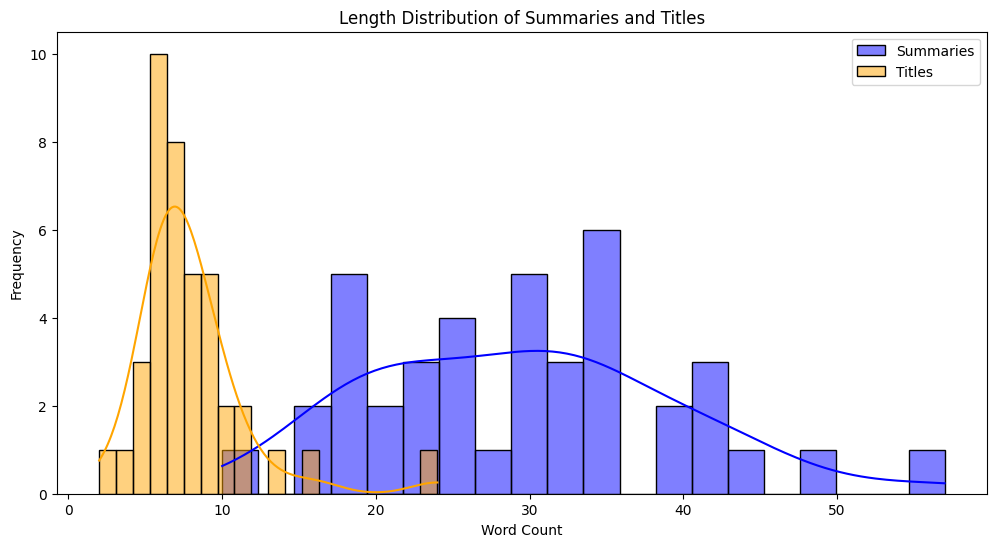

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


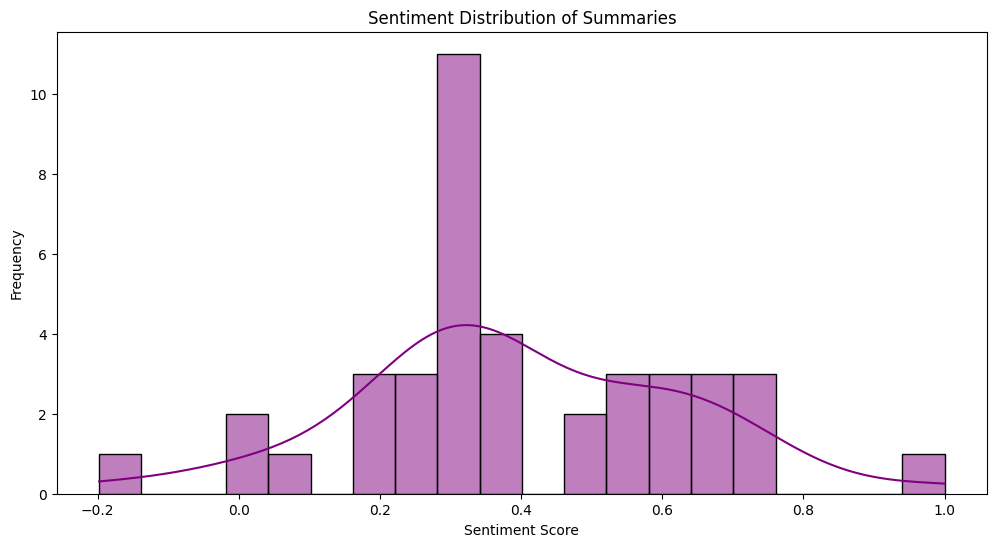

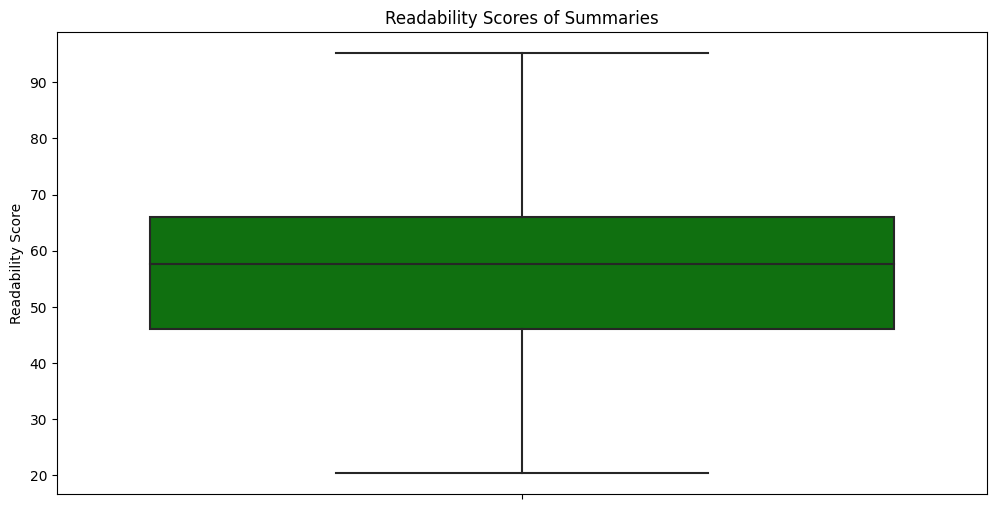

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


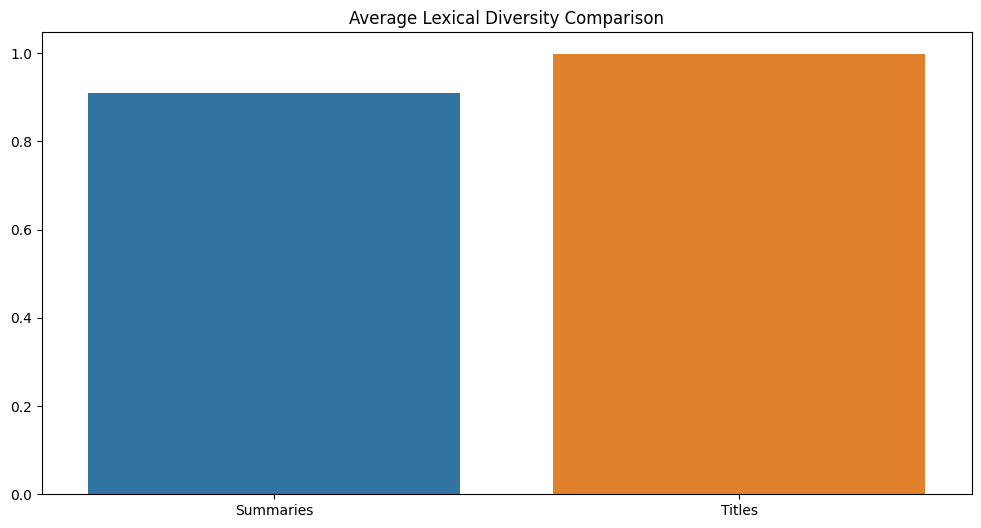

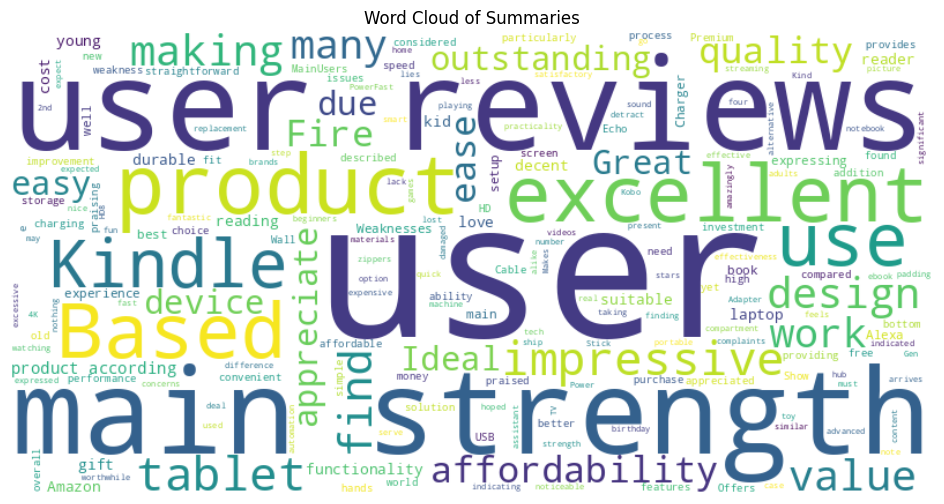

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


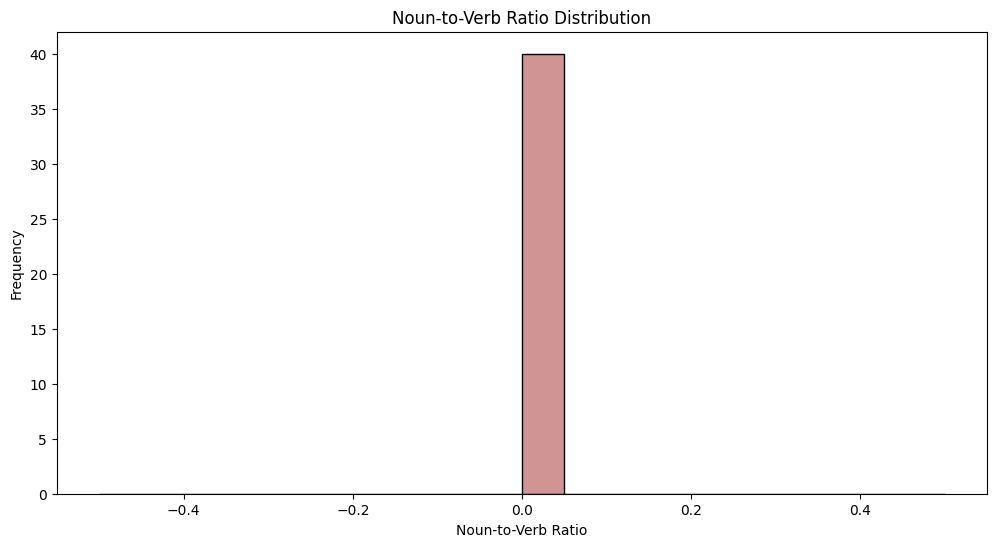

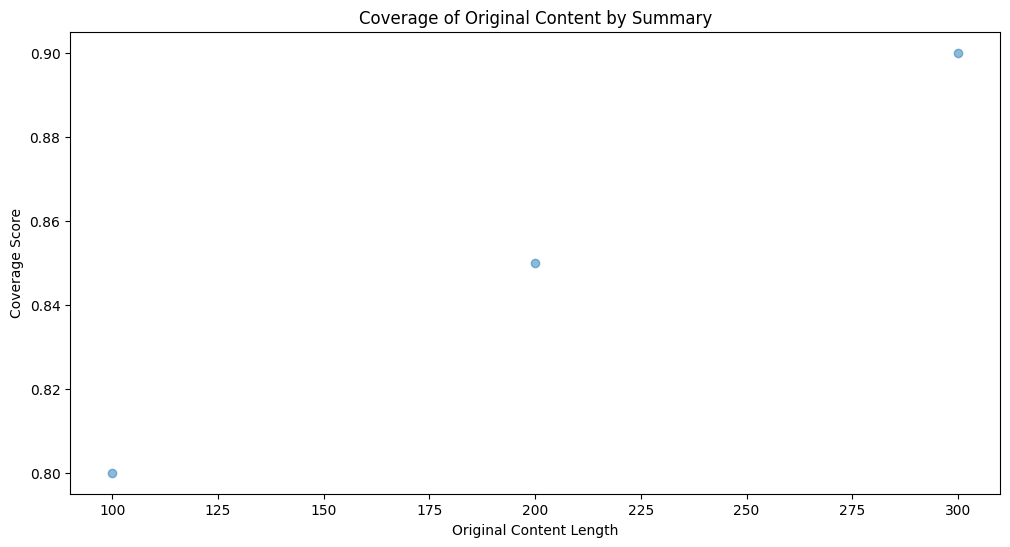

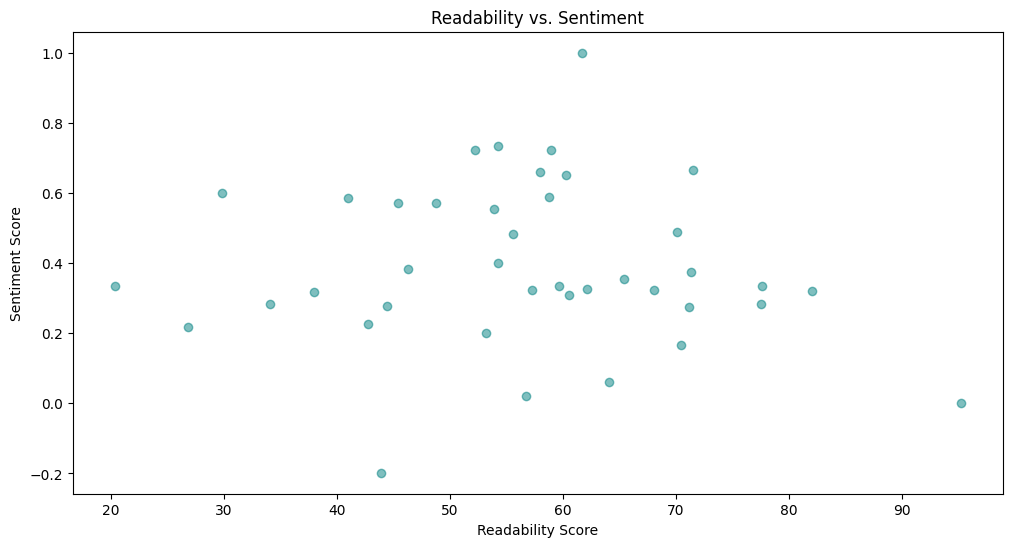

In [22]:
# Sample data for demonstration
generated_summaries = [entry['review_summary'] for entry in results]
generated_titles = [entry['title_summary'] for entry in results]
summary_lengths = [len(summary.split()) for summary in generated_summaries]
title_lengths = [len(title.split()) for title in generated_titles]
readability_scores = [textstat.flesch_reading_ease(summary) for summary in generated_summaries]
sentiment_scores = [TextBlob(summary).sentiment.polarity for summary in generated_summaries]
lexical_diversity_summaries = [len(set(summary.split())) / len(summary.split()) for summary in generated_summaries]
lexical_diversity_titles = [len(set(title.split())) / len(title.split()) for title in generated_titles]
noun_to_verb_ratios = [text.count("NN") / max(1, text.count("VB")) for text in generated_summaries] # Simplified example

# 1. Length Distribution Plot
plt.figure(figsize=(12, 6))
sns.histplot(summary_lengths, bins=20, kde=True, color='blue', label='Summaries')
sns.histplot(title_lengths, bins=20, kde=True, color='orange', label='Titles')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Length Distribution of Summaries and Titles')
plt.legend()
plt.show()

# 2. Sentiment Distribution Plot
plt.figure(figsize=(12, 6))
sns.histplot(sentiment_scores, bins=20, kde=True, color='purple')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution of Summaries')
plt.show()

# 3. Readability Scores Plot
plt.figure(figsize=(12, 6))
sns.boxplot(y=readability_scores, color='green')
plt.ylabel('Readability Score')
plt.title('Readability Scores of Summaries')
plt.show()

# 4. Lexical Diversity Comparison Plot
plt.figure(figsize=(12, 6))
data = {'Type': ['Summaries', 'Titles'],
        'Lexical Diversity': [sum(lexical_diversity_summaries) / len(lexical_diversity_summaries),
                              sum(lexical_diversity_titles) / len(lexical_diversity_titles)]}
sns.barplot(x='Type', y='Lexical Diversity', data=data)
plt.title('Average Lexical Diversity Comparison')
plt.show()

# 5. Word Cloud
all_text = " ".join(generated_summaries)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Summaries')
plt.show()

# 6. Noun-to-Verb Ratio Plot
plt.figure(figsize=(12, 6))
sns.histplot(noun_to_verb_ratios, bins=20, kde=True, color='brown')
plt.xlabel('Noun-to-Verb Ratio')
plt.ylabel('Frequency')
plt.title('Noun-to-Verb Ratio Distribution')
plt.show()

# 7. Coverage Scatter Plot (assuming original_lengths and coverage_scores are defined)
original_lengths = [100, 200, 300]  # Example data; replace with actual values
coverage_scores = [0.8, 0.85, 0.9]  # Example data; replace with actual values
plt.figure(figsize=(12, 6))
plt.scatter(original_lengths, coverage_scores, alpha=0.5)
plt.xlabel('Original Content Length')
plt.ylabel('Coverage Score')
plt.title('Coverage of Original Content by Summary')
plt.show()

# 8. Readability vs. Sentiment Plot
plt.figure(figsize=(12, 6))
plt.scatter(readability_scores, sentiment_scores, alpha=0.5, color='teal')
plt.xlabel('Readability Score')
plt.ylabel('Sentiment Score')
plt.title('Readability vs. Sentiment')
plt.show()
